# ArV_NeuroSynth: GAN-based EEG Simulation for Functional Connectivity Analysis

This notebook demonstrates ArV_NeuroSynth, a novel GAN-based model for simulating EEG signals, supporting the review article "Generative Adversarial Networks for Enhancing EEG Functional Connectivity Analysis in Neuroscience." The code showcases data augmentation, denoising, and the preservation of functional connectivity, addressing key challenges in EEG analysis.

In [15]:
# Cell 1: Install & Imports

# !pip install torch numpy matplotlib scipy

from ArV_NeuroSynth import ArV_NeuroSynth
from load_bci_mat_all_runs import load_bci_mat_all_runs
import torch
import numpy as np
import matplotlib.pyplot as plt

# Cell 2: Data Loading

Load EEG data from all runs in the .mat file. This ensures the model sees diverse brain activity and maximizes the utility of the BCI dataset.

In [16]:
dataloader, eeg_tensor = load_bci_mat_all_runs("A01T.mat", num_channels=4, segment_length=256, batch_size=32)
print("EEG tensor shape:", eeg_tensor.shape)

EEG tensor shape: (4, 671728)


# Cell 3: Model Initialization

Initialize the ArV_NeuroSynth model. This model combines VAE and GAN principles to generate realistic EEG while preserving functional connectivity.

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ArV_NeuroSynth(input_channels=4, seq_length=256, latent_dim=32, noise_dim=50).to(device)
print("Model initialized on device:", device)

Model initialized on device: cpu


# Cell 4: Training Loop

Train the model to reconstruct EEG segments. The loss combines MSE (reconstruction) and KL divergence (regularization), supporting robust and diverse EEG generation.

Epoch 1/40 - Loss: 171.755715
Epoch 2/40 - Loss: 169.842951
Epoch 3/40 - Loss: 163.945529
Epoch 4/40 - Loss: 149.491616
Epoch 5/40 - Loss: 145.177146
Epoch 6/40 - Loss: 141.973111
Epoch 7/40 - Loss: 142.551466
Epoch 8/40 - Loss: 132.160282
Epoch 9/40 - Loss: 126.128776
Epoch 10/40 - Loss: 126.048674
Epoch 11/40 - Loss: 120.396844
Epoch 12/40 - Loss: 118.423227
Epoch 13/40 - Loss: 116.467699
Epoch 14/40 - Loss: 114.466313
Epoch 15/40 - Loss: 113.299716
Epoch 16/40 - Loss: 109.496754
Epoch 17/40 - Loss: 113.586506
Epoch 18/40 - Loss: 107.980632
Epoch 19/40 - Loss: 110.691706
Epoch 20/40 - Loss: 104.291046
Epoch 21/40 - Loss: 106.727571
Epoch 22/40 - Loss: 107.377958
Epoch 23/40 - Loss: 102.937564
Epoch 24/40 - Loss: 103.679524
Epoch 25/40 - Loss: 100.600307
Epoch 26/40 - Loss: 98.006433
Epoch 27/40 - Loss: 97.208647
Epoch 28/40 - Loss: 97.226863
Epoch 29/40 - Loss: 95.634905
Epoch 30/40 - Loss: 94.000455
Epoch 31/40 - Loss: 95.009213
Epoch 32/40 - Loss: 96.852202
Epoch 33/40 - Loss: 101.

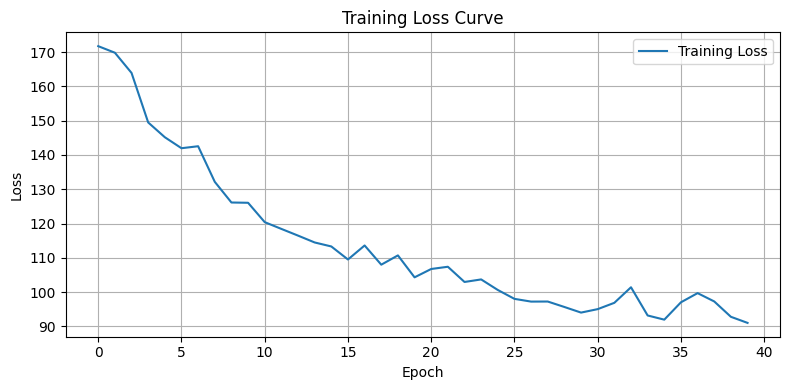

In [21]:
epochs = 40
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
recon_loss_fn = torch.nn.MSELoss()
loss_history = []

model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for x_batch, in dataloader:
        x_batch = x_batch.to(device)
        x_recon, mu, logvar, z = model(x_batch, mode='vae')
        recon_loss = recon_loss_fn(x_recon, x_batch)
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + 0.01 * kl_loss  # 0.01 is a typical beta value for VAE, adjust as needed

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x_batch.size(0)

    avg_loss = epoch_loss / len(dataloader.dataset)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.6f}")

# Plot loss curve
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Cell 5: Save & Load Utilities

Utility functions for saving/loading model weights and results. This ensures reproducibility and easy sharing of trained models.

In [22]:
def save_training_results(model, x_recon=None, plot=False, prefix="arv_neurosynth"):
    """Save model weights, reconstructed EEG, and optionally a plot."""
    torch.save(model.state_dict(), f"{prefix}_trained.pth")
    print(f"Model saved as {prefix}_trained.pth")
    if x_recon is not None:
        np.save(f"{prefix}_reconstructed_eeg.npy", x_recon.cpu().numpy())
        print(f"Reconstructed EEG saved as {prefix}_reconstructed_eeg.npy")
    if plot and x_recon is not None:
        plt.figure(figsize=(12, 4))
        for ch in range(x_recon.shape[1]):
            plt.plot(x_recon.cpu()[0, ch], label=f"Ch{ch}")
        plt.legend()
        plt.title("Reconstructed EEG")
        plt.grid()
        plt.tight_layout()
        plt.savefig(f"{prefix}_reconstruction_plot.png")
        plt.close()
        print(f"Plot saved as {prefix}_reconstruction_plot.png")

def load_trained_model(model_class, prefix="arv_neurosynth", **model_kwargs):
    """Load model weights into a new model instance."""
    model = model_class(**model_kwargs)
    model.load_state_dict(torch.load(f"{prefix}_trained.pth"))
    model.eval()
    print(f"Model loaded from {prefix}_trained.pth")
    return model

# Cell 6: Save Model and Results

Save the trained model and a sample reconstruction for future use and reproducibility.

In [23]:
with torch.no_grad():
    x_real = next(iter(dataloader))[0][:1].to(device)
    x_recon, _, _, _ = model(x_real, mode='vae')
    save_training_results(model, x_recon, plot=True)

Model saved as arv_neurosynth_trained.pth
Reconstructed EEG saved as arv_neurosynth_reconstructed_eeg.npy
Plot saved as arv_neurosynth_reconstruction_plot.png


# Cell 7: Load Model Later

Reload the trained model for inference or further training.

In [24]:
model_loaded = load_trained_model(
    ArV_NeuroSynth,
    input_channels=4, seq_length=256, latent_dim=32, noise_dim=50
)

Model loaded from arv_neurosynth_trained.pth


# Cell 8: Visualize Results

Compare real and reconstructed EEG signals to visually assess model performance.

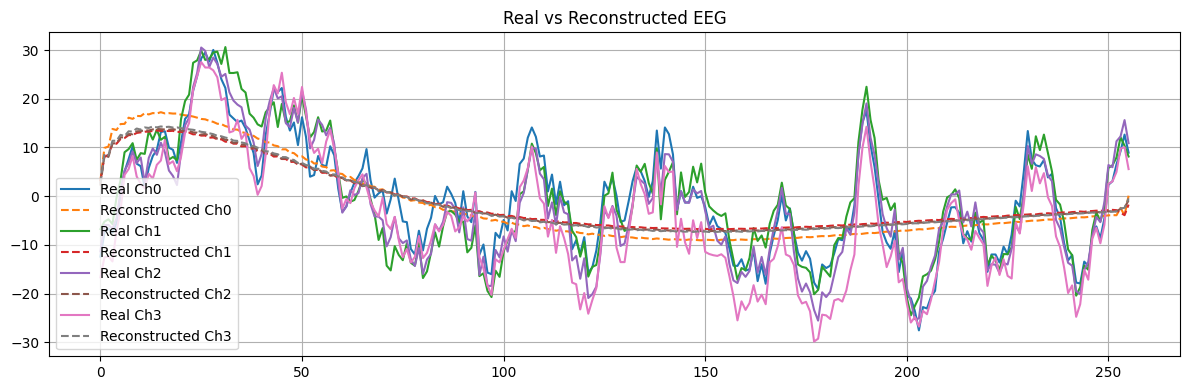

In [25]:
plt.figure(figsize=(12, 4))
for ch in range(x_real.shape[1]):
    plt.plot(x_real.cpu()[0, ch], label=f"Real Ch{ch}")
    plt.plot(x_recon.cpu()[0, ch], '--', label=f"Reconstructed Ch{ch}")
plt.legend()
plt.title("Real vs Reconstructed EEG")
plt.grid()
plt.tight_layout()
plt.show()

# Cell 9: Functional Connectivity Analysis

Compare functional connectivity (correlation matrices) of real and generated EEG to demonstrate the model's ability to preserve brain network structure.

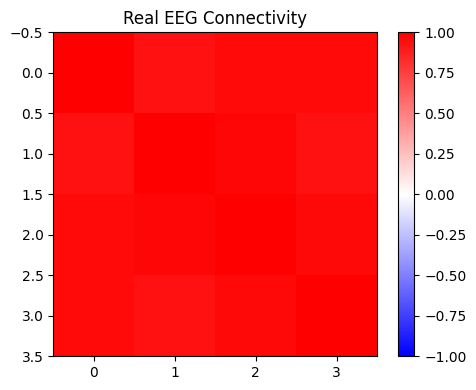

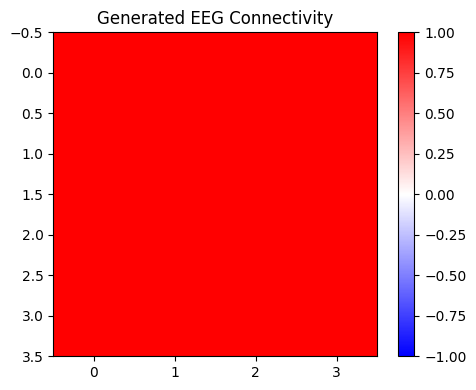

In [26]:
def plot_connectivity(eeg, title):
    # eeg: shape [batch, channels, time]
    conn = np.corrcoef(eeg[0].cpu().numpy())
    plt.figure(figsize=(5,4))
    plt.imshow(conn, cmap='bwr', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_connectivity(x_real, "Real EEG Connectivity")
plot_connectivity(x_recon, "Generated EEG Connectivity")

# Discussion & Future Directions

The ArV_NeuroSynth model demonstrates that GAN-based approaches can generate realistic EEG signals while preserving functional connectivity patterns. This supports the review's claim that GANs are promising for data augmentation, denoising, and simulation in neuroscience. Future work could explore disease-specific simulation, multi-modal integration, and explainable GANs for clinical applications.